In [1]:
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar


import cartopy as cy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from geopy import distance
import math
import re

Oepning  MyWavewam 800m Wave Model spectra file from  
https://thredds.met.no/thredds/fou-hi/mywavewam800.html

In [2]:
OPeNDAP_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/mywavewam800s/MyWave_wam800_c4SPC00.nc'
ds =  xr.open_dataset(OPeNDAP_url)
ds.forecast_reference_time.values

numpy.datetime64('2025-01-03T00:00:00.000000000')

In [3]:
ds

<xarray.Dataset> Size: 223MB
Dimensions:                  (direction: 36, freq: 36, x: 586, y: 1, time: 73)
Coordinates:
  * direction                (direction) float32 144B 5.0 15.0 ... 345.0 355.0
  * freq                     (freq) float32 144B 0.03452 0.03798 ... 0.9702
  * x                        (x) int32 2kB 1 2 3 4 5 6 ... 582 583 584 585 586
  * y                        (y) int32 4B 1
  * time                     (time) datetime64[ns] 584B 2025-01-02T18:00:00 ....
    latitude                 (y, x) float32 2kB ...
    longitude                (y, x) float32 2kB ...
Data variables:
    forecast_reference_time  datetime64[ns] 8B 2025-01-03
    SPEC                     (time, y, x, freq, direction) float32 222MB ...
    Pdir                     (time, y, x) float32 171kB ...
    dd                       (time, y, x) float32 171kB ...
    depth                    (y, x) float32 2kB ...
    ff                       (time, y, x) float32 171kB ...
    hs                       (time, y, x) float32 171kB ...
    thq_sea                  (time, y, x) float32 171kB ...
    thq_swell                (time, y, x) float32 171kB ...
    tp                       (time, y, x) float32 171kB ...
Attributes:
    title:                           MyWaveWam 800m Skagerrak
    institution:                     Norwegian Meteorological Institute
    source:                          WAM wave model version cycle 4.7.0
    direction_convention:            A direction of 0 degrees means a wave pr...
    history:                         Fri Jan  3 04:28:44 2025: ncks -A -v for...
    history_of_appended_files:       Fri Jan  3 04:28:44 2025: Appended file ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

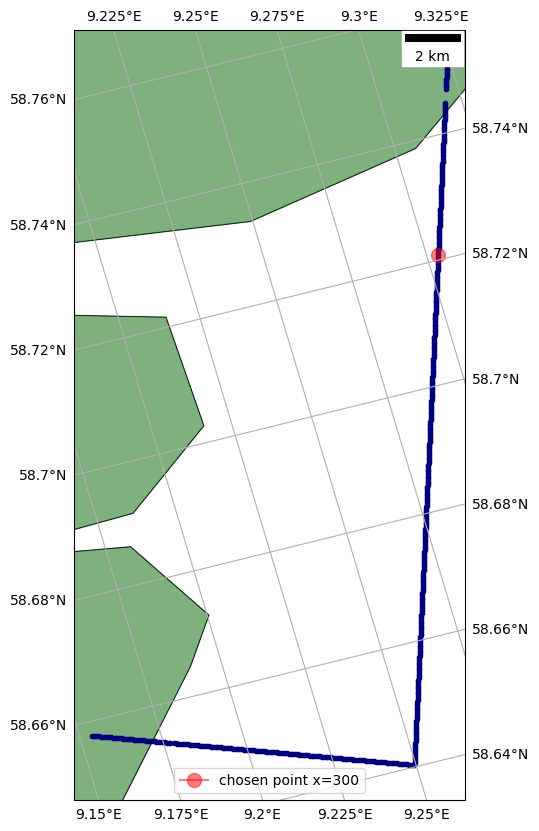

In [4]:
x_spec  = 300
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.Orthographic(-10, 45)})
ax.add_feature(cfeature.LAND, color='darkgreen', alpha=0.5)
ax.scatter(ds.longitude,ds.latitude,marker='.', color='navy', transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=0.5)
ax.plot(ds.longitude.sel(x = x_spec), ds.latitude.sel(x = x_spec), marker='o', alpha = 0.5, color = 'red', markersize=10, label=f"chosen point x={x_spec}", transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.add_artist(ScaleBar(2))
ax.legend(loc='lower center')
plt.show()

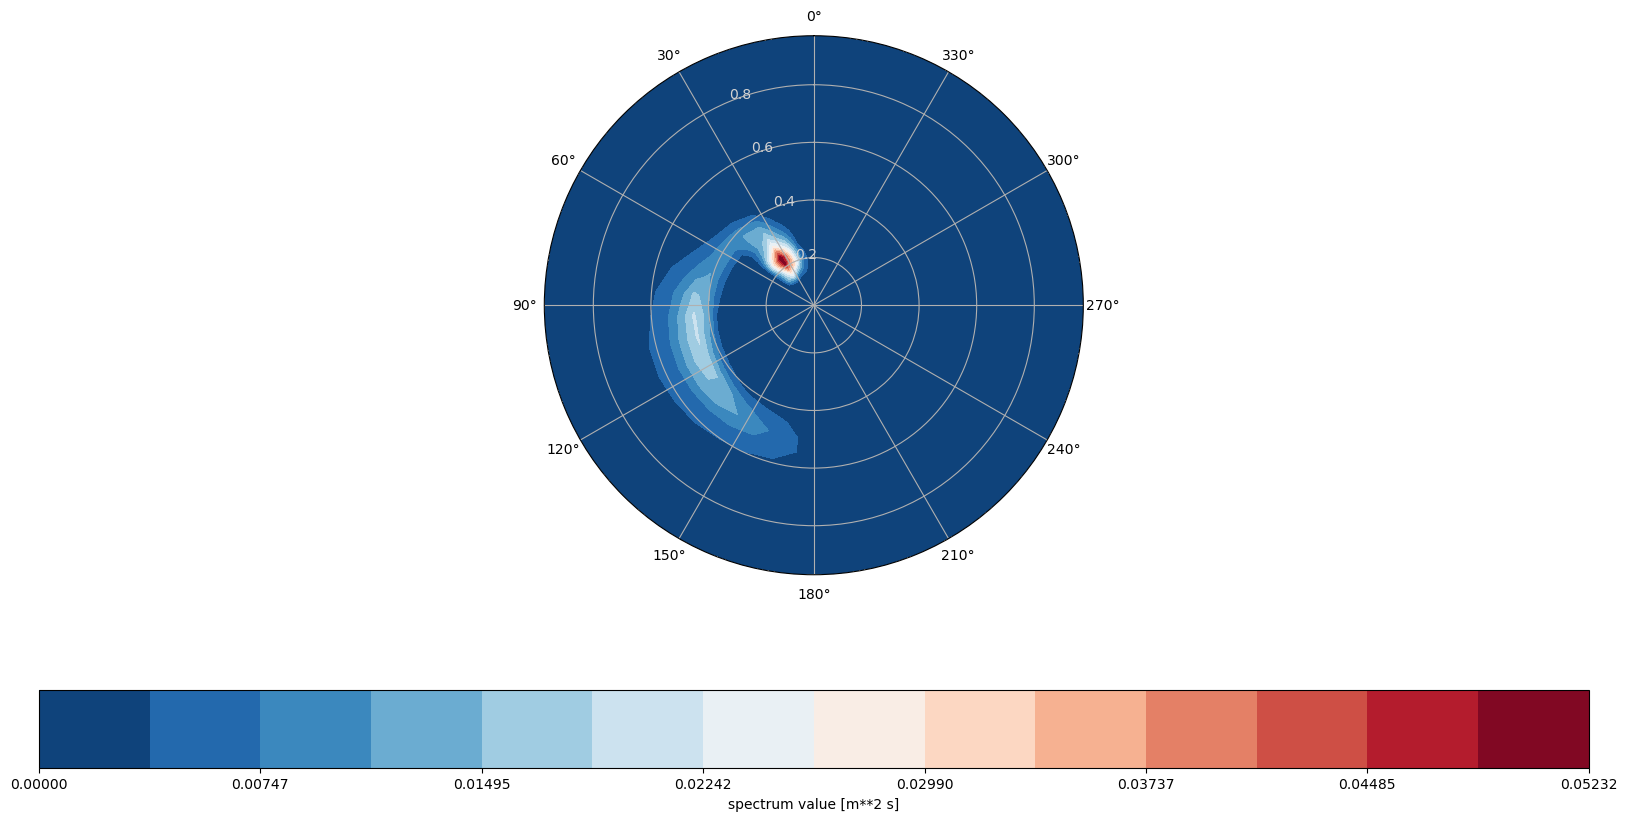

In [5]:
#thetas are 0-360-step angle values expressed in radians thus 0-2pi- step
thetas = [math.radians(deg) for deg in ds.direction.values]
#frequencies are discrete frequencies - equvanet to 1.03 - 28.9 s periods
freqencies = ds.freq.values
time_index = 0
E = ds.isel(time = time_index,  x = 3, y = 0)['SPEC'].values.T

# since thetas are not exactly from 0 to 360, extra step must be added, otherwise the spectrum plot would be wedged
dtheta = np.diff(thetas).mean() # / theta step, they are rather equal
wrapped_theta = np.concatenate((thetas, thetas[-1:] + dtheta))
wrapped_E = np.concatenate((E, E[0:1, :]), axis=0)

#generating meshgrid
[r_coord, th_coord] = np.meshgrid(freqencies,wrapped_theta)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, polar = True)
#beautifying the polar plot 
ax.set_theta_zero_location('N')
ax.set_theta_direction(+1)
ax.tick_params(axis='y', labelcolor='lightgrey', colors='lightgrey')

ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))

cntf = ax.contourf(th_coord, r_coord, wrapped_E, cmap='RdBu_r', 
                   levels=np.linspace(np.min(E), np.max(E), 15))

_ = fig.colorbar(cntf, ax=ax, orientation='horizontal', label='spectrum value [m**2 s]')